In [23]:
import numpy as np
import pandas as pd
import random, copy, os
from matplotlib import pyplot as plt
from multiprocessing import Pool
import multiprocessing
import time
import math
from cvxopt.base import matrix
from cvxopt.modeling import op, dot, variable, max, min

In [24]:
def coordinate_to_index(i, j, matrix):
    edges_count = np.count_nonzero(matrix[:i,:] != 0) + np.count_nonzero(matrix[i,:j] != 0)
    return edges_count

def index_to_coordinate(idx, matrix):
    return list(zip(*np.where(matrix != 0)))[idx]

In [45]:
plt.rcParams['font.size'] = 14
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 19
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['lines.linewidth'] = 2.0

In [53]:
U_num = 50
V_num = 50
T = 100
edge_exist_probability = 0.1
B_u_max = 10
p_f_min = 0.5
Delta = 1
filename = 'Syn_Bumax_{}Delta_{}'.format(B_u_max, Delta)

In [26]:
F = np.zeros((U_num,V_num))
np.random.seed(1)
F[np.random.rand(U_num,V_num) < edge_exist_probability] = 1
F_num = np.count_nonzero(F != 0)
B_u = np.random.randint(1,B_u_max+1,size=U_num)
p_f = p_f_min + np.random.rand(F_num) / 2
w_f = np.random.rand(F_num) / 2
r_v = np.random.rand(V_num)
r_v = np.round(r_v / np.sum(r_v) * T)
p_v = r_v / np.sum(r_v)

In [27]:
E_u = np.zeros((U_num,F_num), dtype=np.float)
E_v = np.zeros((V_num,F_num), dtype=np.float)
E_u_D = np.zeros((U_num,F_num), dtype=np.float)
E_u_D1 = np.zeros((U_num,F_num), dtype=np.float)
E_u_D2 = np.zeros((U_num,F_num), dtype=np.float)
E_v_D1 = np.zeros((V_num,F_num), dtype=np.float)
c = -1
for u in range(U_num):
    for v in range(V_num):
        if F[u,v] != 0:
            c += 1
            E_u[u,c] = 1
            E_v[v,c] = 1
            E_u_D[u,c] = p_f[c] / B_u[u]
            E_u_D1[u,c] = p_f[c]
            E_u_D2[u,c] = 1 / B_u[u]
            E_v_D1[v,c] = p_f[c]

In [28]:
x_f1 = variable(F_num)
x_f2 = variable(F_num)

In [29]:
profit_OBJ = -1 * np.sum(dot(matrix(w_f * p_f),x_f1))
fairness_OBJ = max(-1 * matrix(E_u_D) * x_f2)

In [30]:
ineq1 = []
ineq1.append(matrix(E_u_D1) * x_f1 <= matrix(B_u.flatten().astype('float')))
ineq1.append(matrix(E_v) * x_f1 <= Delta * matrix(r_v.astype('float')))
ineq1.append(matrix(E_v_D1) * x_f1 <= matrix(r_v.astype('float')))
ineq1.append(matrix(E_v) * x_f1 <= matrix(r_v.astype('float')))
ineq1.append(x_f1 >= 0)
ineq2 = []
ineq2.append(matrix(E_u_D1) * x_f2 <= matrix(B_u.flatten().astype('float')))
ineq2.append(matrix(E_v) * x_f2 <= Delta * matrix(r_v.astype('float')))
ineq2.append(matrix(E_v_D1) * x_f2 <= matrix(r_v.astype('float')))
ineq2.append(matrix(E_v) * x_f2 <= matrix(r_v.astype('float')))
ineq2.append(x_f2 >= 0)

In [31]:
profit_opt = op(profit_OBJ, ineq1)
profit_opt.solve()

     pcost       dcost       gap    pres   dres   k/t
 0: -2.5165e+01 -7.1868e+02  1e+03  9e-01  1e+01  1e+00
 1: -1.9396e+01 -1.4595e+02  2e+02  2e-01  3e+00  3e-01
 2: -2.3102e+01 -6.4025e+01  4e+01  5e-02  8e-01  1e-01
 3: -2.7338e+01 -4.0949e+01  1e+01  2e-02  3e-01  5e-02
 4: -2.9053e+01 -3.2028e+01  2e+00  4e-03  6e-02  9e-03
 5: -2.9439e+01 -3.0393e+01  7e-01  1e-03  2e-02  3e-03
 6: -2.9607e+01 -2.9783e+01  1e-01  2e-04  4e-03  3e-04
 7: -2.9652e+01 -2.9671e+01  1e-02  2e-05  4e-04  3e-05
 8: -2.9656e+01 -2.9664e+01  6e-03  1e-05  2e-04  1e-05
 9: -2.9658e+01 -2.9658e+01  7e-05  1e-07  2e-06  2e-07
10: -2.9658e+01 -2.9658e+01  7e-07  1e-09  2e-08  2e-09
Optimal solution found.


In [32]:
fairness_opt = op(fairness_OBJ, ineq2)
fairness_opt.solve()

     pcost       dcost       gap    pres   dres   k/t
 0: -2.8545e-01 -5.8381e+02  1e+03  9e-01  6e+01  1e+00
 1:  5.6075e-01 -1.1550e+02  2e+02  2e-01  1e+01  3e-01
 2:  2.8296e-01 -1.3149e+01  1e+01  2e-02  1e+00  6e-02
 3: -2.7216e-02 -2.9642e+00  2e+00  5e-03  3e-01  1e-02
 4: -1.7160e-02 -2.3080e+00  2e+00  4e-03  2e-01  7e-03
 5: -9.3348e-02 -8.4755e-01  5e-01  1e-03  8e-02  2e-03
 6: -1.3362e-01 -4.0887e-01  2e-01  4e-04  3e-02  6e-04
 7: -1.3374e-01 -1.5855e-01  2e-02  4e-05  3e-03  5e-05
 8: -1.3477e-01 -1.3502e-01  2e-04  4e-07  3e-05  5e-07
 9: -1.3478e-01 -1.3478e-01  2e-06  4e-09  3e-07  5e-09
10: -1.3478e-01 -1.3478e-01  2e-08  4e-11  3e-09  5e-11
Optimal solution found.


In [33]:
profit_opt_value = -1 * profit_opt.objective.value()[0]
fairness_opt_value = -1 * fairness_opt.objective.value()[0]

In [34]:
x_v = E_v * np.asarray(x_f1.value).reshape(F_num)
for v_idx in range(V_num):
    if r_v[v_idx] != 0:
        x_v[v_idx] = x_v[v_idx] / r_v[v_idx]
x_v[np.where(x_v < 0.000001)] = 0
#y_v = np.asarray(matrix(E_v) * matrix(np.asarray(x_f2.value))).reshape(3)
y_v = E_v * np.asarray(x_f2.value).reshape(F_num)
for v_idx in range(V_num):
    if r_v[v_idx] != 0:
        y_v[v_idx] = y_v[v_idx] / r_v[v_idx]
y_v[np.where(y_v < 0.000001)] = 0

In [35]:
num_loops = 500
arrival_seqs = []
np.random.seed(2)
for i in range(num_loops):
    arrival_seqs.append(np.random.choice(range(V_num),size = T,p = p_v))
CRS = []

In [36]:
def GKPS(z, delta_v):
    Z = [0] * len(z)
    z = np.array(z)
    p = z / delta_v
    if sum(p) <= 0.00001:
        return Z
    p = p / sum(p)
    for i in range(delta_v):
        sample_z_index = np.random.choice(np.arange(len(z)), size=1, p=p)[0]
        Z[sample_z_index] = 1
        p[sample_z_index] = 0
        if sum(p) <= 0.00001:
            break
        else:
            p = p / sum(p)
    return Z

In [37]:
def warmup(arrival_seq, alpha, beta):
    B_u_temp = copy.deepcopy(B_u)
    X_f = np.zeros(F_num)
    for v_idx in arrival_seq:
        process_idx = np.random.choice(range(3),size=1,p=[alpha,beta,1-alpha-beta])[0]
        if process_idx <= 1:
            if process_idx == 0: # run on x_f1
                Z_v = GKPS(x_v[v_idx],Delta)
            else: # run on x_f2
                Z_v = GKPS(y_v[v_idx],Delta)
            pi = np.where(E_v[v_idx] != 0)[0]
            np.random.shuffle(pi)
            for f_idx in pi:
                if Z_v[f_idx] == 1 and B_u_temp[index_to_coordinate(f_idx,F)[0]] > 0:
                    temp_p = np.random.random()
                    if temp_p <= p_f[f_idx]:
                        B_u_temp[index_to_coordinate(f_idx,F)[0]] -= 1
                        X_f[f_idx] += 1
    return X_f, np.sum(X_f * w_f), min(matrix(E_u_D2) * matrix(X_f.reshape(F_num)))
# return X_f, np.sum(X_f * w_f), min(matrix(E_u_D2) * matrix(X_f.reshape(F_num)))

In [38]:
alphas, betas = np.arange(0., 1.01, 0.1), 1 - np.arange(0.,1.01,0.1)
WARMUP_results = []
for k in range(len(alphas)):
    WARMUP_params = []
    for i in range(num_loops):
        WARMUP_params.append([arrival_seqs[i], alphas[k], betas[k]])

    with Pool(multiprocessing.cpu_count()) as p:
        tempresult = p.starmap(warmup, WARMUP_params)
    WARMUP_results.append(tempresult)

WARMUP_avg_results = np.average(WARMUP_results, axis=1)
WARMUP_var_results = np.var(WARMUP_results, axis=1)

In [41]:
fairness_crs,profit_crs,profit_errors,fairness_errors = [],[],[],[]

for k in range(len(alphas)):
    fairness_crs.append(min(matrix(E_u_D2) * matrix(WARMUP_avg_results[k][0].reshape(F_num))) / fairness_opt_value)
    profit_crs.append(WARMUP_avg_results[k][1] / profit_opt_value)
    profit_errors.append(WARMUP_var_results[k][1] / profit_opt_value)
    fairness_errors.append(WARMUP_var_results[k][2] / fairness_opt_value)

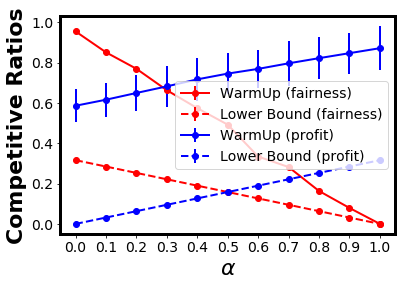

In [54]:
# plt.plot(alphas, fairness_crs)
# plt.plot(alphas, [x * (1-1/np.e) / 2 for x in 1-alphas], linestyle=':')
# plt.plot(alphas, profit_crs)
# plt.plot(alphas, [x * (1-1/np.e) / 2 for x in alphas], linestyle=':')

# plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Competitive Ratios')
ax.set_xticklabels(["{:.1f}".format(x) for x in alphas])
ax.set_xticks(alphas)
colors = ['red', 'red', 'blue', 'blue']
labels = ['WarmUp (fairness)', 'Lower Bound (fairness)', 'WarmUp (profit)', 'Lower Bound (profit)']
linestyles = ['-', '--', '-', '--']

lines = [fairness_crs, [x * (1-1/np.e) / 2 for x in 1-alphas], profit_crs, [x * (1-1/np.e) / 2 for x in alphas]]
errors = [fairness_errors, [0 for x in alphas], profit_errors, [0 for x in alphas]]
for i in range(len(lines)):
    ax.errorbar(alphas, lines[i], yerr=errors[i], color=colors[i], label=labels[i], linestyle=linestyles[i], marker='o')
box = ax.get_position()
ax.legend(loc='best', fontsize='medium')
fig.savefig('plots/{}.pdf'.format(filename), bbox_inches='tight')
plt.show()
plt.close()

In [87]:
def greedy_p(arrival_seq):
    B_u_temp = copy.deepcopy(B_u)
    X_f = np.zeros(F_num)
    for v_idx in arrival_seq:
        nei_us = np.where(F[:,v_idx] != 0)[0]
        max_p_u_idx = -1
        max_p = -1
        for u_idx in nei_us:
            if B_u_temp[u_idx] > 0:
                f_idx = coordinate_to_index(u_idx, v_idx, F)
                current_p = w_f[f_idx] * p_f[f_idx]
                if current_p > max_p:
                    max_p_u_idx = u_idx
                    max_p = current_p
        if max_p_u_idx != -1:
            f_idx = coordinate_to_index(max_p_u_idx, v_idx, F)
            for i in range(Delta):
                temp_p = np.random.random()
                if temp_p <= p_f[f_idx]:
                    B_u_temp[max_p_u_idx] -= 1
                    X_f[f_idx] += 1
                    break
    return X_f, np.sum(X_f * w_f)

In [88]:
def greedy_f(arrival_seq):
    B_u_temp = copy.deepcopy(B_u)
    X_f = np.zeros(F_num)
    for v_idx in arrival_seq:
        nei_us = np.where(F[:,v_idx] != 0)[0]
        min_f_u_idx = -1
        min_f = 2
        for u_idx in nei_us:
            if B_u_temp[u_idx] > 0:
                f_idx = coordinate_to_index(u_idx, v_idx, F)
                current_f = 1 - B_u_temp[u_idx] / B_u[u_idx]
                if current_f < min_f:
                    min_f_u_idx = u_idx
                    min_f = current_f
        if min_f_u_idx != -1:
            f_idx = coordinate_to_index(min_f_u_idx, v_idx, F)
            for i in range(Delta):
                temp_p = np.random.random()
                if temp_p <= p_f[f_idx]:
                    B_u_temp[min_f_u_idx] -= 1
                    X_f[f_idx] += 1
                    break
    return X_f, np.sum(X_f * w_f)
#     return X_f, np.sum(X_f * w_f), min(matrix(E_u_D2) * matrix(X_f.reshape(F_num)))

In [89]:
GreedyP_params = []
GreedyP_results = []
for i in range(num_loops):
    GreedyP_params.append([arrival_seqs[i]])

with Pool(multiprocessing.cpu_count()) as p:
    GreedyP_results = p.starmap(greedy_p, GreedyP_params)
GreedyP_avg_results = np.average(GreedyP_results, axis=0)
greedy_p_profit_cr = GreedyP_avg_results[1] / profit_opt_value
greedy_p_fairness_cr = min(matrix(E_u_D2) * matrix(GreedyP_avg_results[0].reshape(F_num))) / fairness_opt_value

In [107]:
GreedyF_params = []
GreedyF_results = []
for i in range(num_loops):
    GreedyF_params.append([arrival_seqs[i]])

with Pool(multiprocessing.cpu_count()) as p:
    GreedyF_results = p.starmap(greedy_f, GreedyF_params)
GreedyF_avg_results = np.average(GreedyF_results, axis=0)
greedy_f_profit_cr = GreedyF_avg_results[1] / profit_opt_value
greedy_f_fairness_cr = min(matrix(E_u_D2) * matrix(GreedyF_avg_results[0].reshape(F_num))) / fairness_opt_value

In [122]:
run helper.ipynb

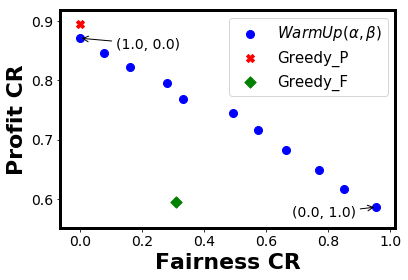

In [124]:
all_x_vals = [fairness_crs , [greedy_p_fairness_cr], [greedy_f_fairness_cr]]
all_y_vals = [profit_crs, [greedy_p_profit_cr], [greedy_f_profit_cr]]
labels = [r'$WarmUp (\alpha, \beta)$', 'Greedy_P', 'Greedy_F']
# annotations = ['({:.1f}, {:.1f})'.format(alphas[i], 1-alphas[i]) for i in range(len(alphas))] + ['', '']
annotations = ['({:.1f}, {:.1f})'.format(alphas[i], 1-alphas[i]) if alphas[i] == 0.0 or alphas[i] == 1.0 or \
               i == np.argmin(fairness_crs) or i == np.argmax(fairness_crs) or i == np.argmin(profit_crs) or \
               i == np.argmax(profit_crs) else '' for i in range(len(alphas))] + ['', '']
annotation_positions = [(fairness_crs[i], 
                         profit_crs[i]) for i in range(len(alphas))]
# print(annotation_positions)
colors = ['blue', 'red', 'green']
shapes = ['o', 'X', 'D']
plot_scatter(all_x_vals, all_y_vals, colors, shapes, annotations, annotation_positions,
             r'$B_u = {}; \Delta_v = {}$'.format(B_u_max,Delta), 
             'Fairness CR', 'Profit CR', 'plots', 'syn_fairness_vs_profit_cr_scatter_{}'.format(filename),
            labels=labels, fmt='pdf', separate_legend=False)